In [7]:
import pandas as pd
import numpy as np

In [8]:
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

Referencias:  
- https://www.kaggle.com/robinteuwens/forecasting-energy-demand  
- https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8
- https://www.kaggle.com/rheajgurung/energy-consumption-forecast  
- https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

### Load Dataset  
Per-hour power consumption data from PJM.
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the East Interconnection Network that features an electrical transmission system that serves all or part of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District. Columbia.

The energy consumption data per hour is available from the PJM website and is in megawatts (MW).

Regions have changed over the years, so data may only1 for certain dates by region.  
Source: Kaggle => https://www.kaggle.com/robikscube/hourly-energy-consumption?select=PJMW_hourly.csv

In [24]:
df = pd.read_csv('Data/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


### Data Clean&Explorer

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


- Time data needs to be converted to panda Datatime format

In [26]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

- Sort them from oldest to most current

In [27]:
df.sort_values('Datetime', axis=0, ascending=True, ignore_index=True, inplace=True)

- Rename the energy column as "MW_demand"

In [28]:
df.rename(columns={'PJME_MW':'MW_demand'}, inplace=True)

- Check and remove duplicates in ''Datetime'

In [29]:
#Check Nan values
df['MW_demand'].isnull().sum()

0

- Check and clean duplicates

In [30]:
#Check duplicates
df.duplicated(subset='Datetime').sum()

4

In [31]:
#Delete duplicates and save the last value
df.drop_duplicates(subset='Datetime', keep='last', inplace=True)

### Resampling (Remuestreo)  
We check the frequency continuity of the Datatime:  
- We select the variable "Datatime" as index and change the data type to Datatime again.  
- We check your frequency. If the data has a constant frequency, df.index.freq will be True, if not (for example, if a few days are missing), df.index.freq will be None.
- We fill in the missing values of the frequency of dates with average values to have a continuity in the time serie.

In [32]:
#We convert the Datetime column to the index and pass it to datatime format
df = df.set_index(pd.to_datetime(df.Datetime)) 

In [33]:
#Drop datetime duplicate column 
df = df.drop('Datetime', 1)
df.head()

,MW_demand
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [34]:
#Check the index type
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145362 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MW_demand  145362 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [35]:
#(None) So it seems that a few hours or days to go in the time series
print(f'df.index.freq is set to: {df.index.freq}') 

df.index.freq is set to: None


We generate a custom date range or frequency between our minimum and maximum dates in our index. From here we compare with our index and check which intervals are missing.

In [38]:
# custom range
maxi= max(df.index)
mini = min(df.index)
date_range = pd.date_range(start=mini, end=maxi, freq='H')

In [17]:
print(f'The difference in length between the custom date range and our dataset is {(len(date_range)-len(df))}:')
print(date_range.difference(df.index))

The difference in length between the custom date range and our dataset is 30:
DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
      

Now we fill the ranges of those 30 missing dates/times in our df with average values.  
To do this we data_range custom data that we have generated as a new index of our df.

In [40]:
df = df.reindex(date_range)

In [41]:
#Now we check that we have those 30 null values that we have artificially entered
df['MW_demand'].isnull().sum() 

30

We fill those 30 values with values using linear interpolation technique between the two consecutive values.

In [42]:
df['MW_demand'].interpolate(method='linear', inplace=True)

In [43]:
#Previous NaN values have now been filled with interpolated values
df['MW_demand'].isnull().sum()

0

We visualize what the time series would look like now that we have all the df

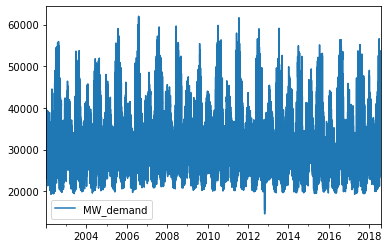

In [152]:
df.plot()

### Features engineering: Time Extraction

In [20]:
# See: https://www.kaggle.com/robikscube/starter-hourly-energy-consumption
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

# let's add the season number
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)

C:\Users\JoseLuisFernandez\miniconda3\envs\dlnn_py36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if __name__ == '__main__':


In [21]:
df.head()

,MW_demand,dow,doy,year,month,quarter,hour,weekday,woy,dom,date,season
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,2002,1,1,1,1,1,1,2002-01-01,1
2002-01-01 02:00:00,29265.0,1,1,2002,1,1,2,1,1,1,2002-01-01,1
2002-01-01 03:00:00,28357.0,1,1,2002,1,1,3,1,1,1,2002-01-01,1
2002-01-01 04:00:00,27899.0,1,1,2002,1,1,4,1,1,1,2002-01-01,1
2002-01-01 05:00:00,28057.0,1,1,2002,1,1,5,1,1,1,2002-01-01,1


We visualize some trends

<AxesSubplot:xlabel='Datetime'>

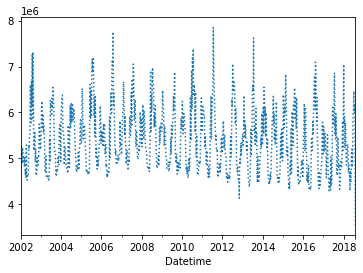

In [58]:
#Resampling for weeks
weekly = df['MW_demand'].resample('W').sum()
weekly.plot(style=[':','--','-'])

In [59]:
#Hourly consumption for each day of the week
dayofweek = df\
    .groupby(['weekday', 'hour'], as_index=False)\
    .agg({'MW_demand':'median'})

In [61]:
dayofweek.head()

,weekday,hour,MW_demand
0,0,0,27906.0
1,0,1,26176.0
2,0,2,25168.0
3,0,3,24546.0
4,0,4,24462.0


<AxesSubplot:xlabel='hour'>

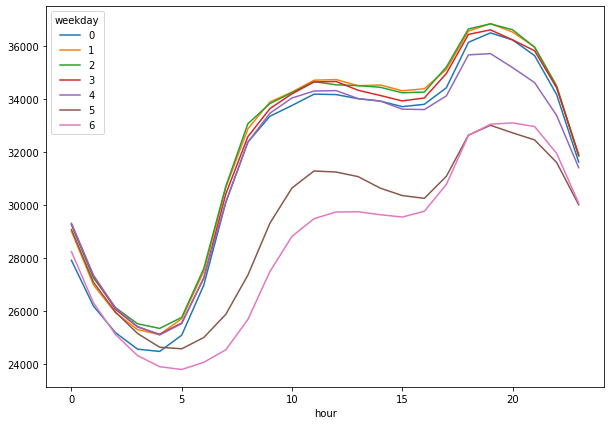

In [62]:
# plot data
fig, ax = plt.subplots(figsize=(10,7))
# use unstack()
dayofweek.groupby(['hour', 'weekday']).mean()['MW_demand'].unstack().plot(ax=ax)

0 corresponds to Monday and 6 to Sunday, you can see that on Tuesdays, Wednesdays and Thursdays they are the ones that demand the most energy. Being around 20:00 in the afternoon the peak of greatest energy needs in a medium day.

In [63]:
#We make an observation of the energy demand during the day according to the season of the year
season = _ = df\
    .groupby(['season','hour'], as_index=False)\
    .agg({'MW_demand':'median'})
season.head()

,season,hour,MW_demand
0,1,0,30877.5
1,1,1,29157.0
2,1,2,28259.0
3,1,3,27882.0
4,1,4,27901.0


<AxesSubplot:xlabel='hour'>

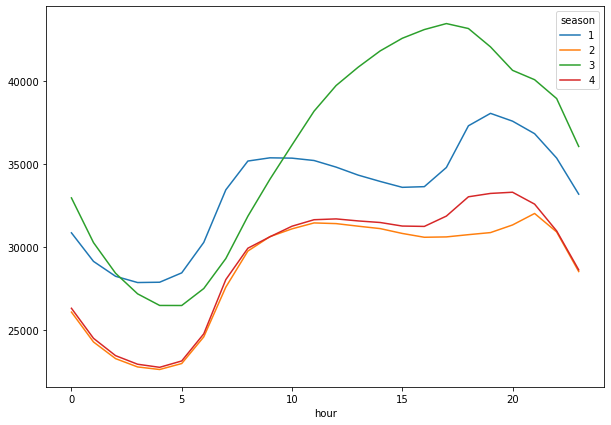

In [64]:
# plot data
fig, ax = plt.subplots(figsize=(10,7))
# use unstack()
season.groupby(['hour', 'season']).mean()['MW_demand'].unstack().plot(ax=ax)

Considering that 1 is winter, 2 spring, 3 summer, 4 autumn. It is appreciated that the demand for higher energy occurs around **18 hours in summer**, presumably by air conditioning. Followed by winter and with less energy demand per day occurs in spring and autumn as they are more timed times.

<AxesSubplot:xlabel='Datetime'>

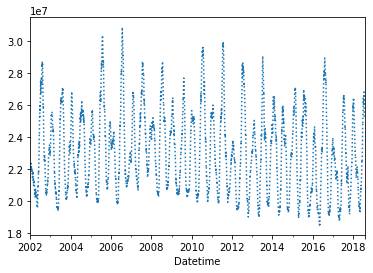

In [65]:
df['MW_demand'].resample('D').sum().rolling(30, center=True).sum().plot(style=[':','--','-'])

<AxesSubplot:xlabel='Datetime'>

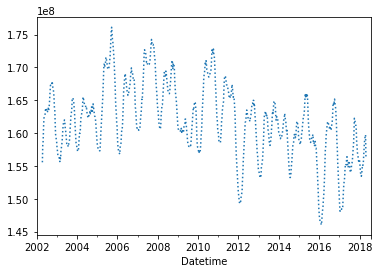

In [66]:
df['MW_demand'].resample('W').sum().rolling(30, center=True).sum().plot(style=[':','--','-'])

When it is done in weekly sample and a 30-week time window there is a **tendency to decrease energy demand** in recent years.

<AxesSubplot:xlabel='Datetime'>

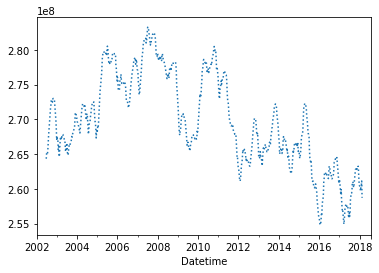

In [67]:
df['MW_demand'].resample('W').sum().rolling(50, center=True).sum().plot(style=[':','--','-'])

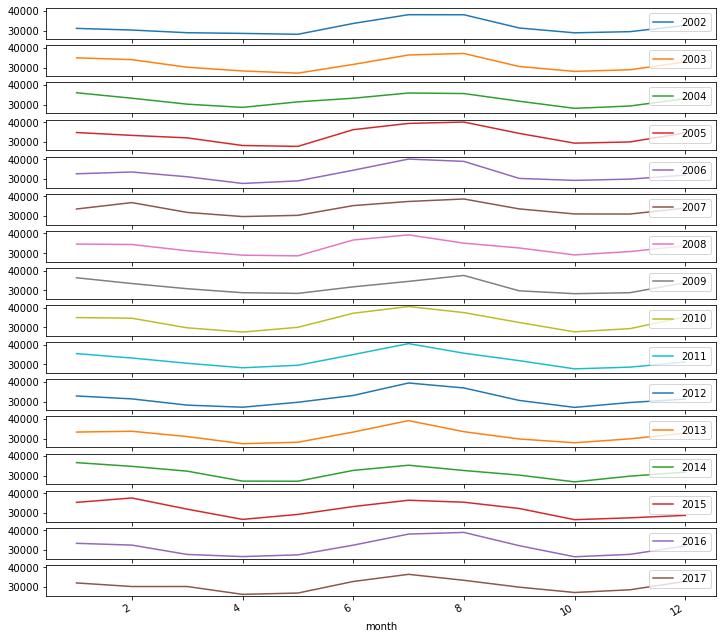

In [61]:
# We try to see the overall trend of each year of the series
df['year'] = df.index.year
df['month'] = df.index.month
pd.pivot_table(df.loc[df ['year'] != 2018], values = 'MW_demand', columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), sharey=True);

It seems that the trend is similar in each year. We don't consider 2018 because there's a lack of year-end data.

<function matplotlib.pyplot.show(*args, **kw)>

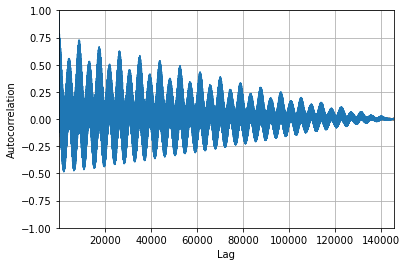

In [221]:
#the autocorrelation graph:
pd.plotting.autocorrelation_plot(df['MW_demand'])
plt.show

The correlogram is a commonly used tool for verifying randomness in a dataset. 
If random, autocorrelations must be close to zero for each and every Time Delay separation Correlogram (https://es.qaz.wiki/wiki/Correlogram)
#Reference: https://www.ibm.com/support/knowledgecenter/es/SS3RA7_sub/modeler_mainhelp_client_ddita/components/dt/timeseries_acf_pacf.html

There seems to be a **clear correlation between the nearly values** that is gradually lost.

### Break down time series data into trend and seasonality
Let's look at the possible trend and seasonality in the time series, using the 'seasonal_decompose' object of the statsmodels library.  
Reference: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

C:\Users\JoseLuisFernandez\miniconda3\envs\dlnn_py36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


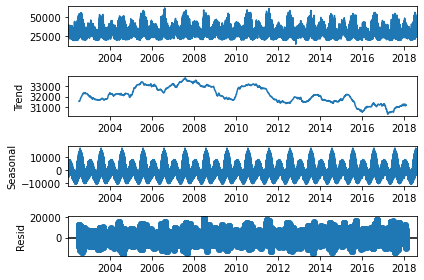

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_decompose needs a dataframe with a datetime index
series = df[['MW_demand']]
frequency = 24*365

# decomposing the time-series, with the frequency being 24 hours per 365 days
result = seasonal_decompose(series, model='additive', freq=frequency)
result.plot();
plt.show();

## Forecasting Models

### 1. Prophet  
<img src="https://miro.medium.com/max/1382/1*HgDtNHGhlgnVg61zf86ZMw.png">  
Facebook Prophet was released in 2017 and is available for Python and R. Prophet is designed to analyze time series with daily observations showing patterns on different timelines. Prophet is robust in the face of missing data and trend changes, and usually handles outliers well. Prophet is probably a good choice for producing quick forecasts, as it has intuitive parameters that can be adjusted by someone who has a good knowledge of the domain but lacks technical skills in forecast models.  
References:  
- https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8
- https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
from fbprophet import Prophet

In [235]:
#Resampling with daily data (D)
daily = df['MW_demand'].resample('D').sum()
#daily

In [253]:
#Prophet algorithm needs two variables "ds" and "y"
df2 = pd.DataFrame()
df2['ds'] = daily.index
df2['y'] = daily.values

In [254]:
df2.head()

,ds,y
0,2002-01-01,714857.0
1,2002-01-02,822277.0
2,2002-01-03,828285.0
3,2002-01-04,809171.0
4,2002-01-05,729723.0


In [258]:
df2_prophet = Prophet(changepoint_prior_scale=0.10)
df2_prophet.fit(df2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [261]:
#Make a future dataframe for 1 year
df2_forecast = df2_prophet.make_future_dataframe(periods=30*12, freq='D')
#Make a prediction
df2_forecast = df2_prophet.predict(df2_forecast)

Text(0.5, 1.0, 'Energy demand forecast')

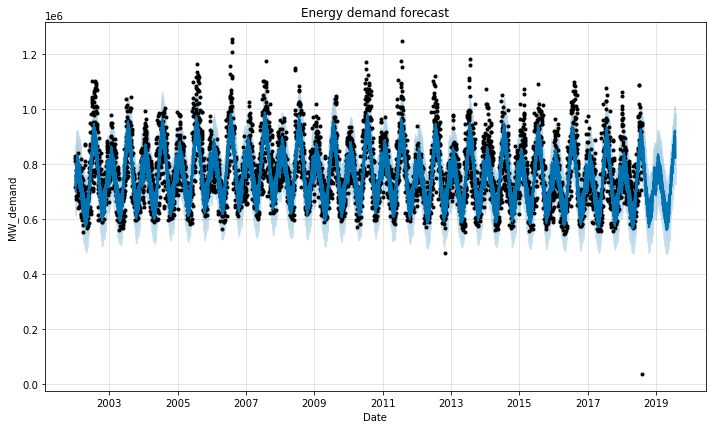

In [262]:
#Make the plot
df2_prophet.plot(df2_forecast, xlabel='Date', ylabel='MW_demand')
plt.title('Energy demand forecast')

One option to try would be to limit to 5 years of data ago to avoid past trends.  
Reference: https://www.kaggle.com/robinteuwens/forecasting-energy-demand

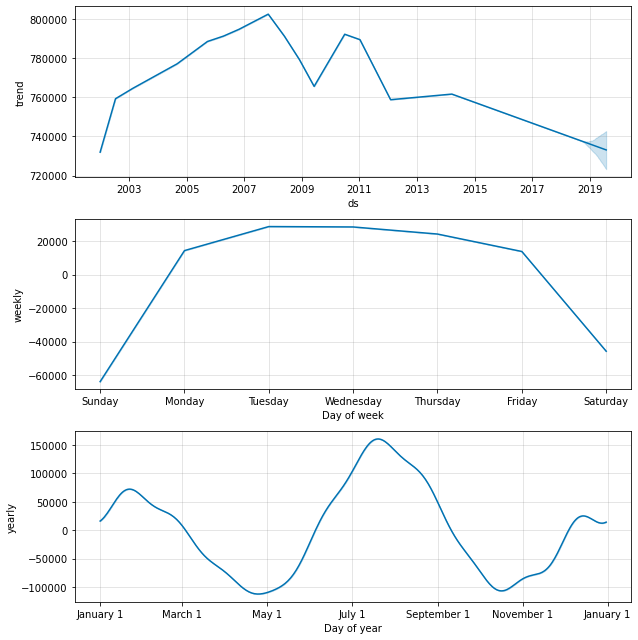

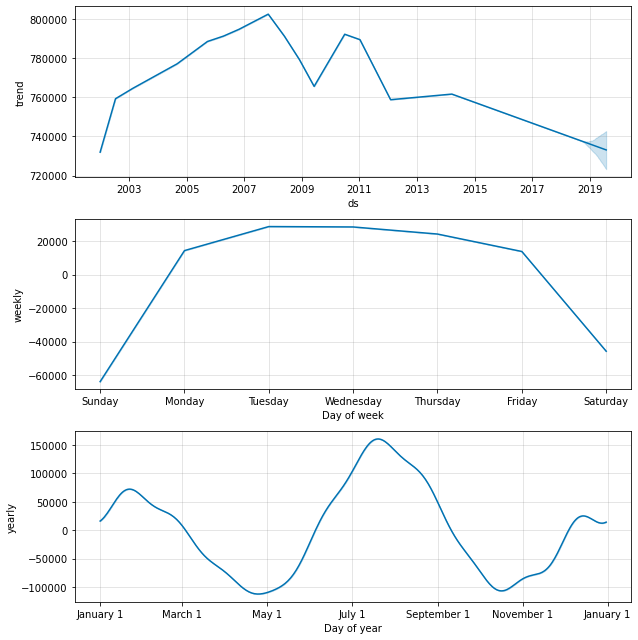

In [264]:
#Viewing time series components
df2_prophet.plot_components(df2_forecast)

The annual pattern is interesting as it seems to suggest that household consumption increases in winter and summer and decreases in spring and autumn. But it also seems, how we had seen it also previously increases more in summer than in winter so you would expect it to be a hot place. Intuitively, this is exactly what we expected to see. Looking at the weekly trend, there seems to be more consumption on weekdays than the weekend. Finally, the general trend suggests that energy consumption has declined in recent years possibly due to improved efficiency of household appliances and appliances.

### 2. LSTM prediction  
The recurring Long Short-Term Memory neural network (LSTM) can learn long sequences of observations.  
References:  
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8

In [10]:
df3 = df[['MW_demand']]
df3.index.name = 'date'
df3.head()

,MW_demand
date,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


LSMs are sensitive to the scale of input data, specifically when using sigmoid or tanh activation functions. In general, it is good practice to change the scale by normalizing the data to the range of [0, 1] or [-1, 1]. We can easily normalize the dataset using the MinMaxScaler preprocessing class of the scikit-learn library.

#### 2.1. Normalización

In [11]:
from sklearn.preprocessing import MinMaxScaler
#I had to solve a problem with the sklearn module when installing keras and tensorflow. This bookstore failed:
#Error: cannot import name 'moduleTNC' from 'scipy optimize'
#Solution: Change on this route->C:\Users\JoseLuisFernandez\miniconda3\envs\dlnn_py36\Lib\site-packages\scipy\optimize
#the file moduletnc.cp36-win_amd64.pyd ---> moduleTNC.cp36-win_amd64.pyd
#Solution reference: https://www.youtube.com/watch?v=3-WvGUy9YZI&ab_channel=VTRICKS

In [12]:
cols_name = df3.columns
scaler = MinMaxScaler()
df3_norm = scaler.fit_transform(df3)
df3_norm = pd.DataFrame(df3_norm, columns=cols_name, index=df3.index)
df3_norm.head()

,MW_demand
date,
2002-01-01 01:00:00,0.333909
2002-01-01 02:00:00,0.310144
2002-01-01 03:00:00,0.291014
2002-01-01 04:00:00,0.281365
2002-01-01 05:00:00,0.284694


#### 2.2. Divide into test and training datasets    
Reference: https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e

In [ ]:
#from sklearn.model_selection import TimeSeriesSplit 
#It would have to be with this specific object for time series but it gets a little complicated

In [207]:
#2 split data series model. 
def train_test_split_series(df_norm, perc_sample):
    train_size = int(len(df_norm) * perc_sample)
    test_size = len(df_norm) - train_size
    #train, test = df_norm[0:train_size,:], df_norm[train_size:len(df_norm),:] #Multivariate
    train, test = df_norm[0:train_size], df_norm[train_size:len(df_norm)] #Univarian
    return train, test
#This function can be further developed by choosing whether it is univarian or multivariate

In [208]:
train, test = train_test_split_series(df3_norm, 0.8)
print(len(train), len(test))

116313 29079


#### 3. Convert time series data on supervised learning problem with the function  `split_squence()`.   
Specific function for the specific case of LSTM. This is a general case for turning a series of time into a supervised learning problem.  
Reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/  

In [209]:
# split a univariate sequence into samples
from numpy import array

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [210]:
# choose a number of time steps
n_steps = 3
# split into samples
x_train, y_train = split_sequence(train.values, n_steps)
x_test, y_test = split_sequence(test.values, n_steps)

In [223]:
#In this case we convert all the data to divide directly into the workout of the fit() model
values = df3_norm.values
values = values.astype('float32')
#values
n_steps = 3
n_features = 1
# split into samples
x_values, y_values = split_sequence(values, n_steps)
x_values = x_values.reshape((x_values.shape[0], values.shape[1], n_features))
print(x_values.shape)
print(y_values.shape)

(145389, 3, 1)
(145389, 1)


The split_sequence() function generates an array (our data) in the form [samples, timesteps], since the LSTM model must be powered by 3D samples [samples, timesteps, features], so we have to modify it to have an additional dimension for the only feature (features) of our case.  

**[samples, timesteps] >> [samples, timesteps, features]**

In [212]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))

In [24]:
x_train.shape

(116310, 3, 1)

In [213]:
x_test.shape

(29076, 3, 1)

#### 4. Define model

In [33]:
#Install tensorflow=2.0 (pip install tensorflow==2.0) in conda prompt
import tensorflow as tf

In [34]:
#Install Keras=2.3.1 (pip install keras==2.3.1) in conda prompt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
#In this format we ask the model to divide the set directly into training and validation in fit()
n_steps = 3
n_features = 1
# define model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
# fit model
lstm_model.fit(x_train, y_train, epochs=200, verbose=0, validation_split=0.2, shuffle=False)

In [35]:
n_steps = 3
n_features = 1
# define model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
# fit model
lstm_model.fit(x_train, y_train, epochs=200, verbose=0, validation_data=(x_test, y_test), shuffle=False)

In [46]:
history = lstm_model.fit(x_train, y_train, epochs=200, verbose=0, validation_data=(x_test, y_test), shuffle=False)

In [67]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


Evaluate and save the model: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [41]:
# evaluate the model
scores = lstm_model.evaluate(x_train, y_train, verbose=0)
print("%s: %.2f%%" % (lstm_model.metrics_names, scores*100))

['loss']: 0.02%


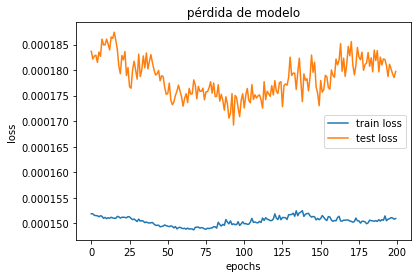

In [66]:
#Plot Model Loss
#Reference: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title (' pérdida de modelo ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

From the loss plot, we can see that the model has an overfit performance, since there is a minimum loss that then starts to go back again. A chart is created that shows the characteristic turning point at the loss of validation of a model that is overfitted. At this point **we should decrease the number of passes by around half (epochs-100) to decrease the loss.**  
References: 
- https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/  
- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [225]:
#In this format we ask the model to divide the set directly into training and validation in the fit()
#without dividing the original data into train and test 
n_steps = 3
n_features = 1
# define model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
# fit model
history2 = lstm_model.fit(x_values, y_values, epochs=100, verbose=0, validation_split=0.2, shuffle=False)

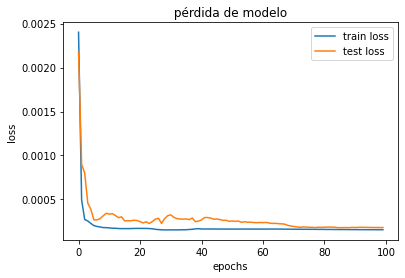

In [227]:
#Plot Model Loss
# Referencia: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='test loss')
plt.title (' pérdida de modelo ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

Un buen ajuste es un caso en el que el rendimiento del modelo es bueno tanto en el conjunto de entrenamiento como en el de  validación.  
Como en este caso, un buen ajuste se puede diagnosticar a partir de una sección donde el conjunto de entrenamiento y la pérdida del conjunto de validación disminuyen y se estabilizan alrededor del mismo punto.

### Prediction  
Reference: https://www.kaggle.com/rheajgurung/energy-consumption-forecast

In [ ]:
yhat = lstm_model.predict(x_values)
# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
inv_yorig = scaler.inverse_transform(y_values)

### Compare Actual data vs. Prediction

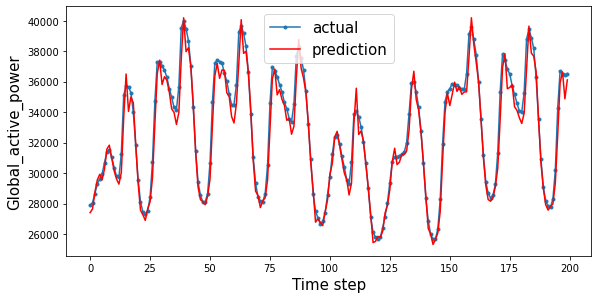

In [299]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, inv_yorig[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[0:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

It seems that a good prediction of the data is shown

### Save the model  
Reference: https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [43]:
# save model and architecture to single file
lstm_model.save("lstm_model.h5")
print("Saved model to disk")

Saved model to disk


In [45]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#### Load a model and see its summary

In [ ]:
from keras.models import load_model
 
# load model
model = load_model("lstm_model.h5")
# summarize model.
model.summary()